In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy as sp

#grafico
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
sns.set(style="whitegrid")

#warning ignore future
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
gc.collect()

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)

from utils import *
#from graphs import *

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

subfolder = "data"
os.listdir(subfolder)

['.ipynb_checkpoints',
 'CONTENT_CATEGORY.zip',
 'CONTENT_CATEGORY_BOTTOM.zip',
 'CONTENT_CATEGORY_TOP.zip',
 'conversiones.zip',
 'data.zip',
 'data2.zip',
 'device_data.zip',
 'PAGE.zip',
 'pageviews.zip',
 'pageviews_complemento.zip',
 'pageview_with_previous_2.csv',
 'sampleSubmission.zip',
 'SITE_ID.zip']

### Config

In [2]:
col_user = 'USER_ID'
one_hot_1 = 'CONNECTION_SPEED'

In [3]:
device = pd.read_csv(
    "{}/device_data.zip".format(subfolder), parse_dates=["FEC_EVENT"], dtype=str
)
device['USER_ID'] = device['USER_ID'].apply(lambda _: str(_).split('.')[0]).astype(int)
device['month'] = device['FEC_EVENT'].dt.month
device['trimestre'] = device['month'].apply(get_trimestre)
device[one_hot_1] = device[one_hot_1].apply(lambda _: 'speed_' + str(_))

device.head()

,FEC_EVENT,CONNECTION_SPEED,IS_MOBILE_DEVICE,USER_ID,month,trimestre
0,2018-11-22 10:15:38,speed_1,1,0,11,4
1,2018-09-11 09:39:41,speed_1,1,0,9,3
2,2018-11-29 16:29:03,speed_3,1,0,11,4
3,2018-05-16 21:12:54,speed_3,1,0,5,2
4,2018-10-12 19:28:23,speed_3,1,0,10,4


In [9]:
device.shape

(2871406, 6)

In [10]:
data = device.copy()

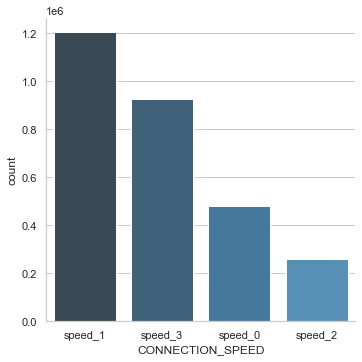

In [11]:
col_ = 'CONNECTION_SPEED'
sns.catplot(
    x=col_,
    data=data[data[col_].isin(list(data[col_].value_counts().head(10).index))], 
    kind="count",
    order = data[col_].value_counts().head(10).index,
    palette=reversed(sns.color_palette('Blues_d'))#"Blues_d" #"ch:s=.25,rot=-.25"
)

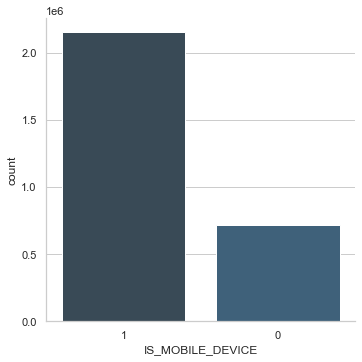

In [12]:
col_ = 'IS_MOBILE_DEVICE'
sns.catplot(
    x=col_,
    data=data[data[col_].isin(list(data[col_].value_counts().head(10).index))], 
    kind="count",
    order = data[col_].value_counts().head(10).index,
    palette=reversed(sns.color_palette('Blues_d'))#"Blues_d" #"ch:s=.25,rot=-.25"
)

In [4]:
device['CONNECTION_SPEED'].unique()

array(['speed_1', 'speed_3', 'speed_0', 'speed_2'], dtype=object)

In [5]:
device['IS_MOBILE_DEVICE'].unique()

array(['1', '0'], dtype=object)

In [7]:
cruce = pd.crosstab(
    index=device[col_user], columns=device[one_hot_1]
).reset_index()
gc.collect()

print(cruce.shape)
gc.collect()
cruce.head()

(11676, 5)


CONNECTION_SPEED,USER_ID,speed_0,speed_1,speed_2,speed_3
0,0,7,396,0,200
1,1,183,29,12,0
2,2,20,182,33,41
3,3,1,300,2,1
4,4,0,224,115,10


In [8]:
treshold = cruce.shape[0]*1/200
treshold

58.38

### Select columns con recurrencia > 1%

In [8]:
cols_del = []
for col in list(cruce.columns)[1:]:
    
    columna = cruce[col]
    size = len(columna[columna > 0])
    
    if size < treshold:
        cols_del.append(col) 

In [9]:
len(cols_del)

0

In [10]:
cruce = cruce.drop(cols_del, axis=1)
print(cruce.shape)

cruce.head()

(11676, 5)


CONNECTION_SPEED,USER_ID,speed_0,speed_1,speed_2,speed_3
0,0,7,396,0,200
1,1,183,29,12,0
2,2,20,182,33,41
3,3,1,300,2,1
4,4,0,224,115,10


In [11]:
cols_select = list(cruce.columns)
del cruce
gc.collect()
len(cols_select)

5

In [12]:
trimestral = []

for trimestre in device['trimestre'].unique():
    print("/"*50, " trimestre: ", trimestre)
    cruce = pd.crosstab(
        device[device['trimestre'] == trimestre][col_user], 
        device[device['trimestre'] == trimestre][one_hot_1]
    ).reset_index()
    
    cols_cruce = list(cruce.columns)
    cols_del = set(cols_cruce) - set(cols_select)
    print("cols_del: ", len(cols_del))
    
    cols_autocompletar = set(cols_select) - set(cols_cruce)
    print("cols_autocompletar: ", len(cols_autocompletar))
    for col in cols_autocompletar:
        cruce[col] = 0
    
    cruce['trimestre'] = trimestre
    
    trimestral.append(cruce[['trimestre'] + cols_select])
    del cols_cruce
    del cruce
    
    gc.collect()

//////////////////////////////////////////////////  trimestre:  4
cols_del:  0
cols_autocompletar:  0
//////////////////////////////////////////////////  trimestre:  3
cols_del:  0
cols_autocompletar:  0
//////////////////////////////////////////////////  trimestre:  2
cols_del:  0
cols_autocompletar:  0
//////////////////////////////////////////////////  trimestre:  1
cols_del:  0
cols_autocompletar:  0


In [13]:
try:
    gc.collect()
    del cruce
    gc.collect
except: 
    pass

In [14]:
save = pd.concat(
    trimestral,
    ignore_index=True,
    axis=0
)

save.shape

(44893, 6)

In [16]:
save.head()

CONNECTION_SPEED,trimestre,USER_ID,speed_0,speed_1,speed_2,speed_3
0,4,0,2,49,0,61
1,4,1,38,15,6,0
2,4,2,0,46,12,16
3,4,3,0,55,2,0
4,4,4,0,40,8,0


In [15]:
save.to_csv('speed_trimestral.csv', index=False)

In [17]:
one_hot_1 = 'IS_MOBILE_DEVICE'

In [18]:
device[one_hot_1] = device[one_hot_1].apply(lambda _: 'device_' + str(_))

cruce = pd.crosstab(
    index=device[col_user], columns=device[one_hot_1]
).reset_index()
gc.collect()

print(cruce.shape)
gc.collect()
cruce.head()

(11676, 3)


IS_MOBILE_DEVICE,USER_ID,device_0,device_1
0,0,0,603
1,1,23,201
2,2,108,168
3,3,5,299
4,4,341,8


In [19]:
treshold

58.38

In [20]:
cols_del = []
for col in list(cruce.columns)[1:]:
    
    columna = cruce[col]
    size = len(columna[columna > 0])
    
    if size < treshold:
        cols_del.append(col) 

In [21]:
cols_select = list(cruce.columns)
del cruce
gc.collect()
len(cols_select)

3

In [22]:
cols_select

['USER_ID', 'device_0', 'device_1']

In [23]:
trimestral = []

for trimestre in device['trimestre'].unique():
    print("/"*50, " trimestre: ", trimestre)
    cruce = pd.crosstab(
        device[device['trimestre'] == trimestre][col_user], 
        device[device['trimestre'] == trimestre][one_hot_1]
    ).reset_index()
    
    cols_cruce = list(cruce.columns)
    cols_del = set(cols_cruce) - set(cols_select)
    print("cols_del: ", len(cols_del))
    
    cols_autocompletar = set(cols_select) - set(cols_cruce)
    print("cols_autocompletar: ", len(cols_autocompletar))
    for col in cols_autocompletar:
        cruce[col] = 0
    
    cruce['trimestre'] = trimestre
    
    trimestral.append(cruce[['trimestre'] + cols_select])
    del cols_cruce
    del cruce
    
    gc.collect()

//////////////////////////////////////////////////  trimestre:  4
cols_del:  0
cols_autocompletar:  0
//////////////////////////////////////////////////  trimestre:  3
cols_del:  0
cols_autocompletar:  0
//////////////////////////////////////////////////  trimestre:  2
cols_del:  0
cols_autocompletar:  0
//////////////////////////////////////////////////  trimestre:  1
cols_del:  0
cols_autocompletar:  0


In [24]:
save = pd.concat(
    trimestral,
    ignore_index=True,
    axis=0
)

save.shape

(44893, 4)

In [25]:
save.head()

IS_MOBILE_DEVICE,trimestre,USER_ID,device_0,device_1
0,4,0,0,112
1,4,1,9,50
2,4,2,19,55
3,4,3,5,52
4,4,4,46,2


In [26]:
save.to_csv('device_trimestral.csv', index=False)